# **Assignment 1 : Experiments with Big data**

### Installing pythons's [boto3](https://github.com/MIT-AI-Accelerator/sevir_challenges) module to connect directly to SEVIR S3 bucket

In [1]:
pip install boto3

     |████████████████████████████████| 132 kB 4.1 MB/s 
     |████████████████████████████████| 8.5 MB 38.4 MB/s 
     |████████████████████████████████| 79 kB 7.9 MB/s 
     |████████████████████████████████| 138 kB 45.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.8 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import boto3
from botocore.handlers import disable_signing
resource = boto3.resource('s3')
resource.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
bucket=resource.Bucket('sevir')

In [3]:
objs=bucket.objects.filter(Prefix='')
print([o.key for o in objs])

['CATALOG.csv', 'data/', 'data/ir069/2018/SEVIR_IR069_RANDOMEVENTS_2018_0101_0430.h5', 'data/ir069/2018/SEVIR_IR069_RANDOMEVENTS_2018_0501_0831.h5', 'data/ir069/2018/SEVIR_IR069_RANDOMEVENTS_2018_0901_1231.h5', 'data/ir069/2018/SEVIR_IR069_STORMEVENTS_2018_0101_0630.h5', 'data/ir069/2018/SEVIR_IR069_STORMEVENTS_2018_0701_1231.h5', 'data/ir069/2019/SEVIR_IR069_RANDOMEVENTS_2019_0101_0430.h5', 'data/ir069/2019/SEVIR_IR069_RANDOMEVENTS_2019_0501_0831.h5', 'data/ir069/2019/SEVIR_IR069_RANDOMEVENTS_2019_0901_1231.h5', 'data/ir069/2019/SEVIR_IR069_STORMEVENTS_2019_0101_0630.h5', 'data/ir069/2019/SEVIR_IR069_STORMEVENTS_2019_0701_1231.h5', 'data/ir107/2018/SEVIR_IR107_RANDOMEVENTS_2018_0101_0430.h5', 'data/ir107/2018/SEVIR_IR107_RANDOMEVENTS_2018_0501_0831.h5', 'data/ir107/2018/SEVIR_IR107_RANDOMEVENTS_2018_0901_1231.h5', 'data/ir107/2018/SEVIR_IR107_STORMEVENTS_2018_0101_0630.h5', 'data/ir107/2018/SEVIR_IR107_STORMEVENTS_2018_0701_1231.h5', 'data/ir107/2019/SEVIR_IR107_RANDOMEVENTS_2019_0101

In [4]:
bucket.download_file('CATALOG.csv','CATALOG.csv')

In [5]:
bucket.download_file('data/vis/2019/SEVIR_VIS_STORMEVENTS_2019_0601_0630.h5','SEVIR_VIS_STORMEVENTS_2019_0601_0630.h5')	

### Accessing the SEVIR data

In [6]:
#DATA_PATH    = 'data'
CATALOG_PATH = 'CATALOG.csv' 

# On some Linux systems setting file locking to false is also necessary:
import os
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'

### Example 1 : Accessing an event

The following code shows how to open a data file directly without using the catalog to visualize frames of an event captured by a single type using the h5py module:

Event ID: b'S822411'
Image shape: (768, 768, 49)


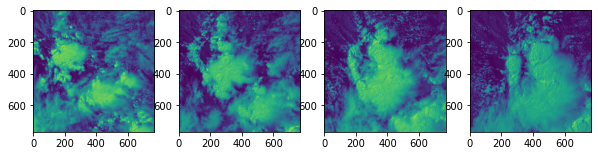

In [7]:
import os
import h5py # needs conda/pip install h5py
import matplotlib.pyplot as plt
 
file_index = 0
with h5py.File('SEVIR_VIS_STORMEVENTS_2019_0601_0630.h5','r') as hf:
    event_id = hf['id'][file_index]
    vis      = hf['vis'][file_index] 
    
print('Event ID:',event_id)
print('Image shape:',vis.shape)

fig,axs=plt.subplots(1,4,figsize=(10,5))
axs[0].imshow(vis[:,:,10])
axs[1].imshow(vis[:,:,20])
axs[2].imshow(vis[:,:,30])
axs[3].imshow(vis[:,:,40])
plt.show()

### Example 2 : Accessing multiple image types using the catalog

The code below shows how to extract an event observed by four image types: vis, vil, ir069 and ir107

In [8]:
import h5py # needs conda/pip install h5py
import matplotlib.pyplot as plt
import pandas as pd  

# Read catalog
catalog = pd.read_csv(CATALOG_PATH,parse_dates=['time_utc'],low_memory=False)

# Desired image types
img_types = set(['vis','ir069','ir107','vil'])

# Group by event id, and filter to only events that have all desired img_types
events = catalog.groupby('id').filter(lambda x: img_types.issubset(set(x['img_type']))).groupby('id')
event_ids = list(events.groups.keys())
print('Found %d events matching' % len(event_ids),img_types)

# Grab a sample event and view catalog entries
sample_event = events.get_group( event_ids[-1])
print('Sample Event:',event_ids[-1])
sample_event

Found 12739 events matching {'ir107', 'ir069', 'vis', 'vil'}
Sample Event: S858968


,id,file_name,file_index,img_type,time_utc,minute_offsets,episode_id,event_id,event_type,llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon,proj,size_x,size_y,height_m,width_m,data_min,data_max,pct_missing
31740,S858968,vis/2019/SEVIR_VIS_STORMEVENTS_2019_0901_0930.h5,75,vis,2019-09-17 19:54:00,-120:-115:-110:-105:-100:-95:-90:-85:-80:-75:-...,142807.0,858968.0,Thunderstorm Wind,46.167805,-94.760806,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,768,768,384000.0,384000.0,0.033034,1.115368,0.0
45328,S858968,ir107/2019/SEVIR_IR107_STORMEVENTS_2019_0701_1...,543,ir107,2019-09-17 19:54:00,-120:-115:-110:-105:-100:-95:-90:-85:-80:-75:-...,142807.0,858968.0,Thunderstorm Wind,46.167805,-94.760806,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,192,192,384000.0,384000.0,-68.275558,20.554308,0.0
46244,S858968,ir069/2019/SEVIR_IR069_STORMEVENTS_2019_0701_1...,544,ir069,2019-09-17 19:54:00,-120:-115:-110:-105:-100:-95:-90:-85:-80:-75:-...,142807.0,858968.0,Thunderstorm Wind,46.167805,-94.760806,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,192,192,384000.0,384000.0,-68.739433,-23.089878,0.0
50085,S858968,vil/2019/SEVIR_VIL_STORMEVENTS_2019_0701_1231.h5,421,vil,2019-09-17 19:54:00,-119:-114:-109:-104:-99:-94:-89:-84:-79:-74:-6...,142807.0,858968.0,Thunderstorm Wind,46.167805,-94.760806,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384,384,384000.0,384000.0,0.000000,254.000000,0.0
74782,S858968,lght/2019/SEVIR_LGHT_ALLEVENTS_2019_0901_1001.h5,0,lght,2019-09-17 19:54:00,NaN,142807.0,858968.0,Thunderstorm Wind,46.167805,-94.760806,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,48,48,384000.0,384000.0,0.000000,453187.000000,0.0


This data frame contains rows for each of the image types in SEVIR corresponding to the listed id. The following code uses rows of sample_event to extract image data for each type:

In [9]:
DATA_PATH = 'data'
file_index = 34
# File index is 34 for vis, 12 for ir069 and ir107
def read_data( sample_event, img_type, data_path=DATA_PATH):
    """
    Reads single SEVIR event for a given image type.
    
    Parameters
    ----------
    sample_event   pd.DataFrame
        SEVIR catalog rows matching a single ID
    img_type   str
        SEVIR image type
    data_path  str
        Location of SEVIR data
    
    Returns
    -------
    np.array
       LxLx49 tensor containing event data
    """
    fn = sample_event[sample_event.img_type==img_type].squeeze().file_name
    fi = sample_event[sample_event.img_type==img_type].squeeze().file_index
    with h5py.File(data_path + '/' + fn,'r') as hf:
        data=hf[img_type][fi] 
    return data

vis = read_data(sample_event, 'vis')
ir069 = read_data(sample_event, 'ir069')
ir107 = read_data(sample_event, 'ir107')
vil = read_data(sample_event, 'vil')

### Example 3 : Including Lightning

To include lightning in the data gathered in Example 2, we first need to convert it to a raster type to display it along with the other image types. The following code achieves this by converting the flash data into flash counts per pixel per 5 minute frame:

In [ ]:
import numpy as np
def lght_to_grid(data):
    """
    Converts SEVIR lightning data stored in Nx5 matrix to an LxLx49 tensor representing
    flash counts per pixel per frame
    
    Parameters
    ----------
    data  np.array
       SEVIR lightning event (Nx5 matrix)
       
    Returns
    -------
    np.array 
       LxLx49 tensor containing pixel counts
    """
    FRAME_TIMES = np.arange(-120.0,125.0,5) * 60 # in seconds
    out_size = (48,48,len(FRAME_TIMES))
    if data.shape[0]==0:
        return np.zeros(out_size,dtype=np.float32)

    # filter out points outside the grid
    x,y=data[:,3],data[:,4]
    m=np.logical_and.reduce( [x>=0,x<out_size[0],y>=0,y<out_size[1]] )
    data=data[m,:]
    if data.shape[0]==0:
        return np.zeros(out_size,dtype=np.float32)

    # Filter/separate times
    # compute z coodinate based on bin locaiton times
    t=data[:,0]
    z=np.digitize(t,FRAME_TIMES)-1
    z[z==-1]=0 # special case:  frame 0 uses lght from frame 1

    x=data[:,3].astype(np.int64)
    y=data[:,4].astype(np.int64)

    k=np.ravel_multi_index(np.array([y,x,z]),out_size)
    n = np.bincount(k,minlength=np.prod(out_size))
    return np.reshape(n,out_size).astype(np.float32)

def read_lght_data( sample_event, data_path=DATA_PATH ):
    """
    Reads lght data from SEVIR and maps flash counts onto a grid  
    
    Parameters
    ----------
    sample_event   pd.DataFrame
        SEVIR catalog rows matching a single ID
    data_path  str
        Location of SEVIR data
    
    Returns
    -------
    np.array 
       LxLx49 tensor containing pixel counts for selected event
    
    """
    fn = sample_event[sample_event.img_type=='lght'].squeeze().file_name
    id = sample_event[sample_event.img_type=='lght'].squeeze().id
    with h5py.File(data_path + '/' + fn,'r') as hf:
        data      = hf[id][:] 
    return lght_to_grid(data)

lght = read_lght_data(sample_event)

# include lightning counts in plot
fig,axs = plt.subplots(1,5,figsize=(14,5))
frame_idx = 30
axs[0].imshow(vis[:,:,frame_idx]), axs[0].set_title('VIS')
axs[1].imshow(ir069[:,:,frame_idx]), axs[1].set_title('IR 6.9')
axs[2].imshow(ir107[:,:,frame_idx]), axs[2].set_title('IR 10.7')
axs[3].imshow(vil[:,:,frame_idx]), axs[3].set_title('VIL')
axs[4].imshow(lght[:,:,frame_idx]), axs[4].set_title('Lightning')

### Example 3b : Adding some color

Example 3 used the default colormap to display the data. To display colorized images similar to those seen in Figure 1, colormaps are available in the repo located here: https://github.com/MIT-AI-Accelerator/eie-sevir. This code requires the module sevir found in this repo to be in your path:

In [ ]:
import sys
sys.path.append('../') # add sevir module to path
from sevir.display import get_cmap
# Get colormaps for encoded types
vis_cmap,vis_norm,vis_vmin,vis_vmax = get_cmap('vis',encoded=True)
ir069_cmap,ir069_norm,ir069_vmin,ir069_vmax = get_cmap('ir069',encoded=True)
ir107_cmap,ir107_norm,ir107_vmin,ir107_vmax = get_cmap('ir107',encoded=True)
vil_cmap,vil_norm,vil_vmin,vil_vmax = get_cmap('vil',encoded=True)
lght_cmap,lght_norm,lght_vmin,lght_vmax = get_cmap('lght',encoded=True)

fig,axs = plt.subplots(1,5,figsize=(14,5))
frame_idx = 30
axs[0].imshow(vis[:,:,frame_idx],cmap=vis_cmap,norm=vis_norm,vmin=vis_vmin,vmax=vis_vmax), axs[0].set_title('VIS')
axs[1].imshow(ir069[:,:,frame_idx],cmap=ir069_cmap,norm=ir069_norm,vmin=ir069_vmin,vmax=ir069_vmax), axs[1].set_title('IR 6.9')
axs[2].imshow(ir107[:,:,frame_idx],cmap=ir107_cmap,norm=ir107_norm,vmin=ir107_vmin,vmax=ir107_vmax), axs[2].set_title('IR 10.7')
axs[3].imshow(vil[:,:,frame_idx],cmap=vil_cmap,norm=vil_norm,vmin=vil_vmin,vmax=vil_vmax), axs[3].set_title('VIL')
axs[4].imshow(lght[:,:,frame_idx],cmap=lght_cmap,norm=lght_norm,vmin=lght_vmin,vmax=lght_vmax), axs[4].set_title('Lightning')


## **Georeferencing SEVIR Events**

In many applications it's necessary to know the lat/lon positions of pixels in a SEVIR patch. The catalog provides the required information to perform the georeferencing the data.

Currently, all patches in SEVIR use the same map projection, a Lambert Equal Area projection centered at (lat,lon)=(38,-98). This specifics of the projection are stored in the proj column:

In [ ]:
sample_event.proj.values[0]

This string uses the Proj4 syntax for defining a map projection.

The class below encodes the formulas for this particular projection. Using this, it's possible to convert between pixel and lat/lon coordinates for each event in SEVIR.

In [ ]:
import re
import numpy as np
class LaeaProjection():
    """
    Translates between pixel coordinates (X,Y) and Lat lon coordinates for a given SEVIR event
    projected in laea.
    
    Parameters
    ----------
    event  pd.Series
        One row from SEVIR catalog
    """
    def __init__(self,event):
        self.proj = event.proj 
        self.lat0 = float(re.compile('\+lat_0=([+-]?\d+)').search(self.proj).groups()[0])
        self.lon0 = float(re.compile('\+lon_0=([+-]?\d+)').search(self.proj).groups()[0])
        self.R = float(re.compile('\+a=(\d+)').search(self.proj).groups()[0])
        self.llcrnlat = event.llcrnrlat
        self.llcrnlon = event.llcrnrlon
        self.refX, self.refY = self.forward(self.llcrnlon,self.llcrnlat,pixel=False)
        self.binX = event.width_m / event.size_x
        self.binY = event.height_m / event.size_y
        
    def forward(self,lon,lat,pixel=True):
        """
        Maps lat/lon to pixel x,y.  For projection coordinates instead of pixel, set pixel=False.
        """
        sind = lambda t: np.sin(t*np.pi/180)
        cosd = lambda t: np.cos(t*np.pi/180)
        k = self.R * np.sqrt(2/(1+sind(self.lat0)*sind(lat)+cosd(self.lat0)*cosd(lat)*cosd(lon-self.lon0)))
        x = k*cosd(lat)*sind(lon-self.lon0)
        y = k*(cosd(self.lat0)*sind(lat) - sind(self.lat0)*cosd(lat)*cosd(lon-self.lon0))
        if pixel:
            x = (x-self.refX) / self.binX
            y = (y-self.refY) / self.binY
        return x,y
    def inverse(self,x,y,pixel=True):
        """
        Maps pixel coordinates to (lon,lat) position.  If passing projection corrdinates, set pixel=False.
        """
        if pixel:
            x = x*self.binX + self.refX
            y = y*self.binY + self.refY
        x/=self.R
        y/=self.R
        sind = lambda t: np.sin(t*np.pi/180)
        cosd = lambda t: np.cos(t*np.pi/180)
        rho = np.sqrt(x*x+y*y)
        c = 2*np.arcsin(0.5*rho)
        sinc = np.sin(c)
        cosc = np.cos(c)
        lat = 180/np.pi*np.arcsin(cosc*sind(self.lat0)+y*sinc*cosd(self.lat0)/rho)
        lon = self.lon0+180/np.pi*np.arctan(x*sinc/(rho*cosd(self.lat0)*cosc - y*sind(self.lat0)*sinc))
        return lon,lat

### Example 4 : Georeferencing an event

Using this class, we can get a grid of latitudes and longitudes for the grids in Examples 2 & Example 3. Note that when we plot the images in this cell, we set origin='lower' so that the positive y dimension corresponds with increasing latitudes (i.e. northward)

In [ ]:
proj = LaeaProjection( sample_event[sample_event.img_type=='vil'].squeeze() )
X,Y = np.meshgrid(np.arange(vil.shape[0]),np.arange(vil.shape[0]))
lons,lats = proj.inverse(X,Y)

# Plot with origin='lower' so up corresponds to north.
fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(vil[:,:,20],origin='lower')
la = ax[1].imshow(lats,origin='lower') 
fig.colorbar(la,ax=ax[1]) 
ax[1].set_title('Pixel Latitudes')
lo = ax[2].imshow(lons,origin='lower') 
fig.colorbar(lo,ax=ax[2]) 
ax[2].set_title('Pixel Longitudes')


This particular domain overlaps with north eastern Minnesota. We can add markers for particular locations by converting from lat/lon coordinates into the image pixel coordinates:

In [ ]:
lat,lon = 46.7867, -92.1005 # Duluth, MN
x,y=proj.forward(lon,lat)
print('x=%f,y=%f' % (x,y))
# Plot with origin='lower' so up corresponds to north.
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.imshow(vil[:,:,20],origin='lower')
ax.plot(x,y,linestyle='none', marker="o", markersize=16, alpha=0.6, c="red")
ax.text(x-30,y-30,'Duluth, MN',color='r')

### Example 4b : Use Basemap instead

There are a number of python modules that compute these conversions for you, and allow you to visualize the georeferenced result with features like coast lines, state borders and other nice map features. pyproj is a popular module for computing geospatial transformations. Basemap and Cartopy are nice plotting libraries. The cell below shows how perform the georeferencing done in Example 4, but instead using the Basemap library:

In [ ]:
# Note:  Requires basemap module to run
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.basemap import Basemap # conda/pip install basemap basemap-data-hires
# Create Basemap Object
s=sample_event[sample_event.img_type=='vil'].squeeze() 
fig,ax=plt.subplots(1,1,figsize=(7,7))
m = Basemap(llcrnrlat=s.llcrnrlat, llcrnrlon=s.llcrnrlon,
            urcrnrlat=s.urcrnrlat,urcrnrlon=s.urcrnrlon,
            width=s.width_m, height=s.height_m,
            lat_0=38, lon_0=-98,
            projection='laea',
            resolution='i',
            ax=ax)
m.drawstates(color='w')
m.drawcoastlines(color='w')
m.drawcountries(color='w')
m.imshow(vil[:,:,24])

lat,lon = 46.7867, -92.1005 # Duluth, MN
x,y=m(lon,lat) # will be in projection coordinates
m.plot(x,y,linestyle='none', marker="o", markersize=16, alpha=0.6, c="red")
ax.text(x-30e3,y-30e3,'Duluth, MN',color='r')